# Testing K nearest neigbours

Using the features file to separate into labels and features

In [11]:
import pandas as pd
import numpy as np

data = pd.read_csv('feature_dataset.csv') 
data.fillna(0, inplace=True)
X = data[['border', 'asymmetry', 'White', 'Black', 'Red', 
          'Light-brown', 'Dark-brown', 'Blue-gray']]

data['cancer'] = data['cancer'].astype(int)
y = data['cancer']
groups = data['patient_id']
unique_patients = data['patient_id'].unique()

Checking features

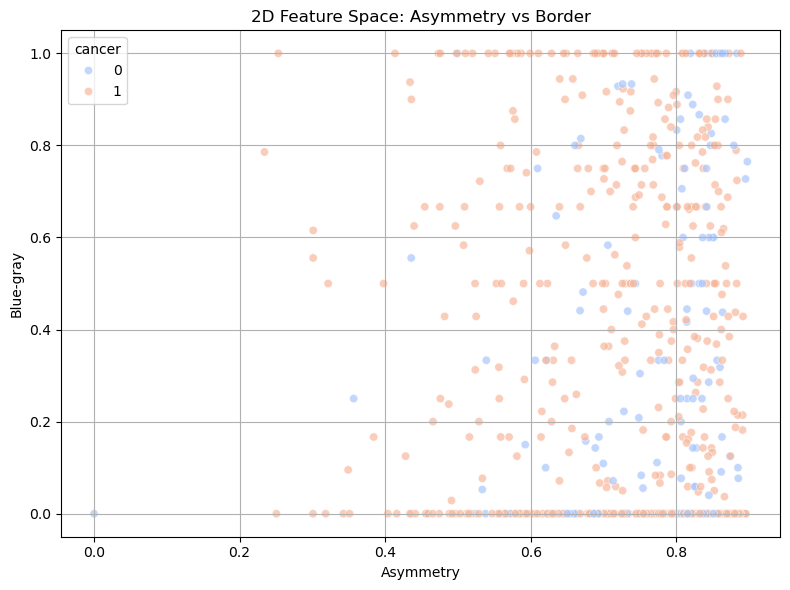

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data, 
    x='border', 
    y='Blue-gray', 
    hue='cancer', 
    palette='coolwarm', 
    alpha=0.7
)
plt.title("2D Feature Space: Asymmetry vs Border")
plt.xlabel("Asymmetry")
plt.ylabel("Blue-gray")
plt.grid(True)
plt.tight_layout()
plt.show()


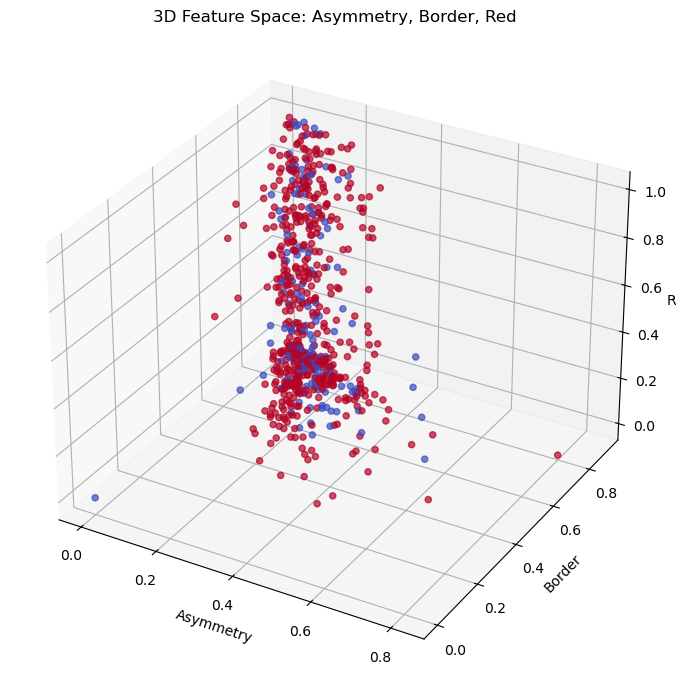

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot
ax.scatter(
    data['asymmetry'], 
    data['border'], 
    data['Blue-gray'], 
    c=data['cancer'], 
    cmap='coolwarm', 
    alpha=0.7
)

ax.set_title("3D Feature Space: Asymmetry, Border, Red")
ax.set_xlabel("Asymmetry")
ax.set_ylabel("Border")
ax.set_zlabel("Red")
plt.tight_layout()
plt.show()


Running cross-validation over different k values (get AUC)

In [18]:
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

#split data into training and test sets (by patient ID)
unique_patients = data['patient_id'].unique()
train_ids, test_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)
train_idx = data['patient_id'].isin(train_ids)

X_train, y_train = X[train_idx], y[train_idx]
groups_train = groups[train_idx]

#standardScaler on training data (within pipeline below)
#GroupKFold CV with k from 3 to 10
cv = GroupKFold(n_splits=5)
k_values = range(1, 101, 2)
summary = []

for k in k_values:
    pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
    auc_scores = cross_val_score(pipe, X_train, y_train, cv=cv, groups=groups_train, scoring='roc_auc')
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    print(f"k={k}, AUC={mean_auc:.4f} ± {std_auc:.4f}")
    summary.append({'k': k, 'mean_auc': mean_auc, 'std_auc': std_auc})

summary_df = pd.DataFrame(summary)

k=1, AUC=0.5496 ± 0.0466
k=3, AUC=0.5587 ± 0.0868
k=5, AUC=0.5763 ± 0.0975
k=7, AUC=0.5888 ± 0.0989
k=9, AUC=0.5961 ± 0.0972
k=11, AUC=0.6069 ± 0.1158
k=13, AUC=0.6319 ± 0.1109
k=15, AUC=0.6387 ± 0.1127
k=17, AUC=0.6228 ± 0.1121
k=19, AUC=0.6266 ± 0.0990
k=21, AUC=0.6268 ± 0.1005
k=23, AUC=0.6365 ± 0.0923
k=25, AUC=0.6337 ± 0.0909
k=27, AUC=0.6317 ± 0.0830
k=29, AUC=0.6410 ± 0.0752
k=31, AUC=0.6392 ± 0.0638
k=33, AUC=0.6361 ± 0.0595
k=35, AUC=0.6375 ± 0.0686
k=37, AUC=0.6363 ± 0.0677
k=39, AUC=0.6411 ± 0.0698
k=41, AUC=0.6469 ± 0.0644
k=43, AUC=0.6405 ± 0.0620
k=45, AUC=0.6396 ± 0.0495
k=47, AUC=0.6442 ± 0.0497
k=49, AUC=0.6446 ± 0.0521
k=51, AUC=0.6423 ± 0.0481
k=53, AUC=0.6435 ± 0.0479
k=55, AUC=0.6390 ± 0.0483
k=57, AUC=0.6407 ± 0.0459
k=59, AUC=0.6373 ± 0.0450
k=61, AUC=0.6373 ± 0.0503
k=63, AUC=0.6351 ± 0.0533
k=65, AUC=0.6390 ± 0.0587
k=67, AUC=0.6364 ± 0.0566
k=69, AUC=0.6317 ± 0.0555
k=71, AUC=0.6241 ± 0.0512
k=73, AUC=0.6172 ± 0.0552
k=75, AUC=0.6084 ± 0.0551
k=77, AUC=0.6148 

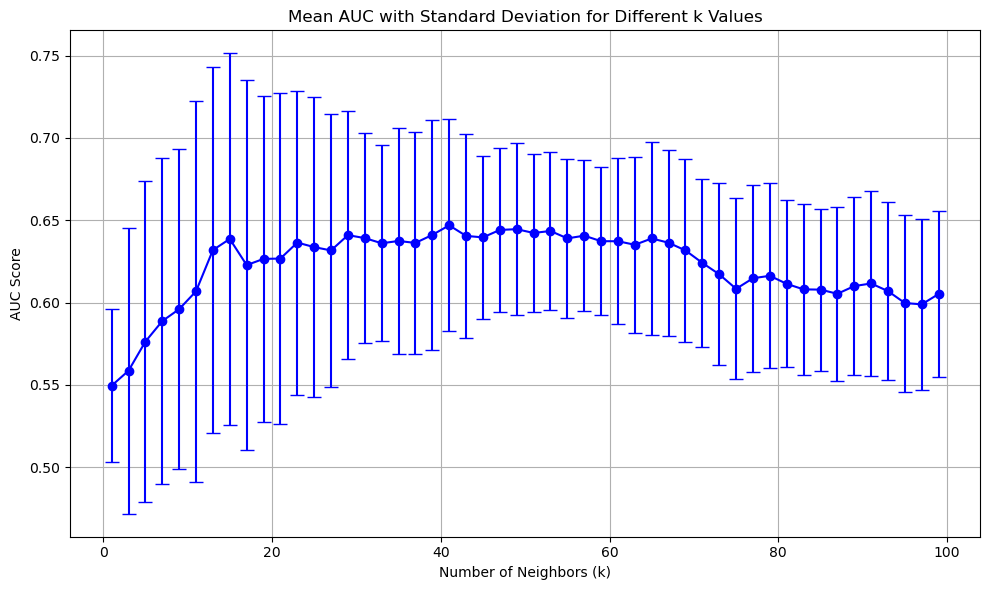

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.errorbar(summary_df['k'], summary_df['mean_auc'], yerr=summary_df['std_auc'], 
             fmt='-o', capsize=5, color='blue')
plt.title('Mean AUC with Standard Deviation for Different k Values')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('AUC Score')
plt.grid(True)
plt.tight_layout()
plt.show()